In [16]:
# Dependancies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import requests
import time
from pprint import pprint
import gmaps
import gmaps.geojson_geometries
from config import gkey, ckey

## Load crime statistics by state and filter for 2017

In [25]:
# Load crime statistics by state for all years
crime_df = pd.read_csv('data/crime_by_state.csv')

# Filter out all years except for 2017 (the latest). 
crime2017_df = crime_df[crime_df['year'] == 2017]
crime2017_df.head()

,year,state_abbr,state_id,population,aggravated_assault,arson,burglary,homicide,larceny,motor_vehicle_theft,property_crime,rape_legacy,rape_revised,robbery,violent_crime
17,2017,AL,2,4874747,18902,703.0,31477,404,99842,12841,144160,0,2028.0,4217,25551
56,2017,AK,1,739795,4257,139.0,4171,62,17775,4258,26204,0,863.0,951,6133
103,2017,AZ,5,7016270,24207,1183.0,37627,416,147830,19058,204515,0,3581.0,7440,35644
119,2017,AR,3,3004279,12425,534.0,21862,258,63374,7253,92489,0,2053.0,1935,16671
161,2017,CA,6,39536653,104454,8648.0,176690,1830,642033,168391,987114,0,14721.0,56622,177627


## Crime statistics per 100 people

- Remove all columns except 'violent crime' and 'property crime'
- Normalize by state population
- Sort dataframe to see top five and bottom five states
- Create a list of five worst and five best states for agency data requests

In [26]:
crime2017_df = crime2017_df[['state_abbr', 'violent_crime', 'property_crime', 'population']]
crime2017_df['violent_crime_per100'] = crime2017_df['violent_crime']*100/crime2017_df['population']
crime2017_df['property_crime_per100'] = crime2017_df['property_crime']*100/crime2017_df['population']
crime2017_df['total_crime_per100'] = crime2017_df['violent_crime_per100']+crime2017_df['property_crime_per100']
crime2017_df.head()

,state_abbr,violent_crime,property_crime,population,violent_crime_per100,property_crime_per100,total_crime_per100
17,AL,25551,144160,4874747,0.524150,2.957282,3.481432
56,AK,6133,26204,739795,0.829013,3.542062,4.371076
103,AZ,35644,204515,7016270,0.508019,2.914868,3.422887
119,AR,16671,92489,3004279,0.554909,3.078576,3.633484
161,CA,177627,987114,39536653,0.449272,2.496706,2.945978


In [27]:
top_five= crime2017_df.sort_values(by = ['total_crime_per100'], ascending = False)[:5]
top_five

,state_abbr,violent_crime,property_crime,population,violent_crime_per100,property_crime_per100,total_crime_per100
1171,NM,16359,82306,2088070,0.783451,3.941726,4.725177
56,AK,6133,26204,739795,0.829013,3.542062,4.371076
682,LA,26092,157712,4684333,0.557006,3.366797,3.923803
1522,SC,25432,160575,5024369,0.506173,3.195924,3.702097
119,AR,16671,92489,3004279,0.554909,3.078576,3.633484


In [28]:
bottom_five = crime2017_df.sort_values(by = ['total_crime_per100'], ascending = True)[:5]
bottom_five

,state_abbr,violent_crime,property_crime,population,violent_crime_per100,property_crime_per100,total_crime_per100
1093,NH,2668,18555,1342795,0.198690,1.381819,1.580509
1734,VT,1034,8960,623657,0.165796,1.436687,1.602483
721,ME,1617,20133,1335907,0.121041,1.507066,1.628107
1132,NJ,20604,140086,9005644,0.228790,1.555536,1.784325
781,MA,24560,98575,6859819,0.358027,1.436991,1.795018


In [29]:
worst = list(top_five['state_abbr'])
best = list(bottom_five['state_abbr'])
worst_best = worst+best
worst_best

['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA']

[]

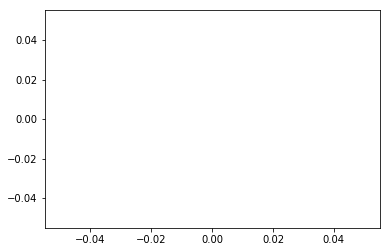

In [30]:
plt.figure()
plt.plot()

## Prepare state data for mapping

- Create a normalized colormap
- Update the state dataframe to add two missing territories (DC and Puerto Rico) 
- Turn the colormap into an list of hex colors, based on the level of crime
- Load states geometry from gmaps
- Plot

In [31]:
max_crime = max(crime2017_df['total_crime_per100'])
crime_val = crime2017_df['total_crime_per100']/max(crime2017_df['total_crime_per100'])
crime_val = crime_val.tolist()

In [32]:
norm = colors.Normalize(vmin=min(crime_val), vmax = max(crime_val))

m = cm.ScalarMappable(norm = norm, cmap='OrRd')
colormap = m.to_rgba(crime_val)
clr = [colors.to_hex(c) for c in colormap]

colorcoded_states = pd.Series(clr, index = crime2017_df['state_abbr'])
colorcoded_states = colorcoded_states.to_frame()

state_abbr = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN",
              "IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV",
              "NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN",
              "TX","UT","VT","VA","WA","WV","WI","WY"]

states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

state_dict = dict(zip(state_abbr, states))

state_names = pd.Series(states, index = state_abbr)
state_names = state_names.to_frame()

state_color = colorcoded_states.merge(state_names, right_index = True, left_index = True)
state_color = state_color.rename(index=str, columns={"0_x": "color", "0_y": "state"})
state_dict

{'AL': 'Alabama',
 'AK': 'Alaska',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming'}

In [33]:
states_geo = gmaps.geojson_geometries.load_geometry('us-states')

# get list of states as they are ordered in gmaps
st = [i['properties']['NAME'] for i in states_geo['features']]

# find territories, missing in the original dataframe and present in the 'us-states' geojson file
missing = [s for s in st if s not in states]

# Add the territories to the frame and color them white 
missing_df = pd.DataFrame([['#ffffff', missing[0]], ['#ffffff', missing[1]]], columns=list(state_color), index = ['DC', 'PR'])
state_color = state_color.append(missing_df)
state_order = pd.DataFrame(pd.Series(st), columns = ['state'])

# create a state-color dataframe for geojson layer
df = state_order.merge(state_color, on = 'state')

In [34]:
# Create a layer for color coded states
gmaps.configure(api_key = gkey)
fig = gmaps.figure()
states_layer = gmaps.geojson_layer(states_geo, 
                                   fill_color = list(df['color']))
fig.add_layer(states_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Map all mass shooting incidents reported between 2014 and 2019

In [35]:
shootings = pd.read_csv('data/shootings_all_years.csv')
shootings['Total Victims Count'] = shootings['# Killed'] + shootings['# Injured']
most_victims = shootings.sort_values(by = ['Total Victims Count'], ascending = False)
most_victims.head(10)

,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations,state_abbr,lat,lon,Year,Total Victims Count
1056,"October 1, 2017",Nevada,Las Vegas,3950 Las Vegas Blvd S,59,441,NaN,NV,36.093392,-115.176337,2017,500
849,"June 12, 2016",Florida,Orlando,1912 S Orange Avenue,50,53,NaN,FL,28.519612,-81.376846,2016,103
1022,"November 5, 2017",Texas,Sutherland Springs,216 4th St,27,20,NaN,TX,29.273218,-98.056343,2017,47
286,"December 2, 2015",California,San Bernardino,1365 South Waterman Avenue,16,19,NaN,CA,34.075564,-117.277623,2015,35
1642,"February 14, 2018",Florida,Pompano Beach (Parkland),5901 Pine Island Rd,17,17,NaN,FL,26.304503,-80.269457,2018,34
505,"May 17, 2015",Texas,Waco,4671 S Jack Kultgen Fwy,9,18,NaN,TX,31.499200,-97.148148,2015,27
1154,"July 1, 2017",Arkansas,Little Rock,220 W 6th St,0,25,NaN,AR,34.743509,-92.273262,2017,25
1571,"May 18, 2018",Texas,Santa Fe,16000 Hwy 6,10,13,NaN,TX,29.392694,-95.141993,2018,23
779,"July 25, 2016",Florida,Fort Myers,3580 Evans Ave,2,19,NaN,FL,26.611218,-81.860602,2016,21
1540,"June 17, 2018",New Jersey,Trenton,635 S Clinton Ave,1,19,NaN,NJ,40.210333,-74.754737,2018,20


In [36]:
locations = [tuple(coord) for coord in shootings[['lat', 'lon']].values]
victims = list(shootings['Total Victims Count'])
max(victims)

500

In [37]:
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights= victims, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 100
heat_layer.point_radius = 1

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Obtain all agency reports for the top five and bottom five states

Source: FBI Crime Data API, official estimates fron the Universal Crime Reports (UCR), compiled and published by FBI  
Time range: 2014 - 2017

- Read a list of agencies from .csv file
- Filter the list to exclude the states which are not in the top of bottom five
- Request all reports from agencies in  ['NM', 'AK', 'LA', 'SC', 'AR', 'NH', 'VT', 'ME', 'NJ', 'MA'] states
- Save all reports as a .csv file fr future use
- Read into a dataframe and clean it (group by year and county, sum up all violent crime and property crime)
- Save as a new csv file

In [38]:
# Read a list of a
agencies = pd.read_csv('data/agencies.csv')
agencies_df = agencies[agencies['State'].isin(worst_best)].reset_index()

# export_csv = reports_df.to_csv (r'data/reports_by_agency_10states.csv', index = None, header=True)

In [39]:
num

3150

In [50]:
# reports_by_agency = []

# num = len(agencies_df)
# count = 0
# for i in range(2926, num):

#     ori = agencies_df['Agency ORI9'][i]

#     try:
#         query_url = f'https://api.usa.gov/crime/fbi/sapi/api/summarized/agencies/{ori}/offenses/2014/2017?api_key={ckey}'
#         response = requests.get(query_url)
#         print('==========================================')
#         print(f'Requesting report from agency {ori}')
#         count +=1
#         result = response.json()
#         report_dict = result['results']
#         print(f'Adding {i} report of {num} | agency ORI9 is {ori} | Request count {count}')
#         reports_by_agency.append(pd.DataFrame(report_dict))
#     except:
#         print('............................................')
#         print(f'Something went wrong, skipping agency {ori}...')

Requesting report from agency MA0010000
............................................
Something went wrong, skipping agency MA0010000...
Requesting report from agency MA001MD00
............................................
Something went wrong, skipping agency MA001MD00...
Requesting report from agency MA0010100
Adding 2928 report of 3150 | agency ORI9 is MA0010100 | Request count 3
Requesting report from agency MA0010200
Adding 2929 report of 3150 | agency ORI9 is MA0010200 | Request count 4
Requesting report from agency MA0010300
Adding 2930 report of 3150 | agency ORI9 is MA0010300 | Request count 5
Requesting report from agency MA0010400
Adding 2931 report of 3150 | agency ORI9 is MA0010400 | Request count 6
Requesting report from agency MA0010500
Adding 2932 report of 3150 | agency ORI9 is MA0010500 | Request count 7
Requesting report from agency MA0010600
Adding 2933 report of 3150 | agency ORI9 is MA0010600 | Request count 8
Requesting report from agency MA0010700
Adding 2934 repo

Requesting report from agency MA0040300
Adding 2977 report of 3150 | agency ORI9 is MA0040300 | Request count 52
Requesting report from agency MA0040100
Adding 2978 report of 3150 | agency ORI9 is MA0040100 | Request count 53
Requesting report from agency MA0040000
............................................
Something went wrong, skipping agency MA0040000...
Requesting report from agency MA004MD00
............................................
Something went wrong, skipping agency MA004MD00...
Requesting report from agency MA0040200
Adding 2981 report of 3150 | agency ORI9 is MA0040200 | Request count 56
Requesting report from agency MA004BA00
............................................
Something went wrong, skipping agency MA004BA00...
Requesting report from agency MA0040500
Adding 2983 report of 3150 | agency ORI9 is MA0040500 | Request count 58
Requesting report from agency MA004MV00
............................................
Something went wrong, skipping agency MA004MV00...
Requ

Requesting report from agency MA0070600
Adding 3028 report of 3150 | agency ORI9 is MA0070600 | Request count 103
Requesting report from agency MA0070700
Adding 3029 report of 3150 | agency ORI9 is MA0070700 | Request count 104
Requesting report from agency MA0070000
............................................
Something went wrong, skipping agency MA0070000...
Requesting report from agency MA007MD00
............................................
Something went wrong, skipping agency MA007MD00...
Requesting report from agency MA0070800
Adding 3032 report of 3150 | agency ORI9 is MA0070800 | Request count 107
Requesting report from agency MA0070900
Adding 3033 report of 3150 | agency ORI9 is MA0070900 | Request count 108
Requesting report from agency MA0072600
............................................
Something went wrong, skipping agency MA0072600...
Requesting report from agency MA0071000
Adding 3035 report of 3150 | agency ORI9 is MA0071000 | Request count 110
Requesting report from

Requesting report from agency MA0100100
Adding 3078 report of 3150 | agency ORI9 is MA0100100 | Request count 153
Requesting report from agency MA010MV00
............................................
Something went wrong, skipping agency MA010MV00...
Requesting report from agency MA310SP00
Adding 3080 report of 3150 | agency ORI9 is MA310SP00 | Request count 155
Requesting report from agency MA0110100
Adding 3081 report of 3150 | agency ORI9 is MA0110100 | Request count 156
Requesting report from agency MA0110200
Adding 3082 report of 3150 | agency ORI9 is MA0110200 | Request count 157
Requesting report from agency MA0110300
Adding 3083 report of 3150 | agency ORI9 is MA0110300 | Request count 158
Requesting report from agency MA0110400
Adding 3084 report of 3150 | agency ORI9 is MA0110400 | Request count 159
Requesting report from agency MA0110500
Adding 3085 report of 3150 | agency ORI9 is MA0110500 | Request count 160
Requesting report from agency MA0110600
Adding 3086 report of 3150

Requesting report from agency MA013MV00
............................................
Something went wrong, skipping agency MA013MV00...
Requesting report from agency MA0130400
Adding 3130 report of 3150 | agency ORI9 is MA0130400 | Request count 205
Requesting report from agency MA313SP00
Adding 3131 report of 3150 | agency ORI9 is MA313SP00 | Request count 206
Requesting report from agency MA0130600
............................................
Something went wrong, skipping agency MA0130600...
Requesting report from agency MA0140100
Adding 3133 report of 3150 | agency ORI9 is MA0140100 | Request count 208
Requesting report from agency MA0147000
............................................
Something went wrong, skipping agency MA0147000...
Requesting report from agency MA0140200
Adding 3135 report of 3150 | agency ORI9 is MA0140200 | Request count 210
Requesting report from agency MA0140300
Adding 3136 report of 3150 | agency ORI9 is MA0140300 | Request count 211
Requesting report from

In [53]:
reports_df = reports_by_agency[0].append(reports_by_agency[1:], ignore_index = True)
# export_csv = reports_df.to_csv (r'data/reports_by_agency_10states_3.csv', index = None, header=True)

In [68]:
files = ['data/reports_by_agency_10states.csv',
        'data/reports_by_agency_10states_1.csv',
        'data/reports_by_agency_10states_2.csv',
        'data/reports_by_agency_10states_3.csv']

dfObj = []

for file in files:
    df = pd.read_csv(file)
    dfObj.append(df)
    
allreports = dfObj[0].append(dfObj[1:], ignore_index = True)
allreports = allreports.rename(index = str, columns = {'ori': 'Agency ORI9'})
allreports = allreports.merge(agencies_df, how = 'left')
# export_csv = allreports.to_csv (r'data/all_agency_reports_10states.csv', index = None, header=True)

In [45]:
allreports = pd.read_csv('data/all_agency_reports_10states.csv')
allreports[allreports['County'] == 'BRISTOL']

,actual,cleared,data_year,offense,Agency ORI9,state_abbr,index,County,State,Agency Name
180,1705,1035,2014,aggravated-assault,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT
181,81,19,2014,arson,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT
182,1375,133,2014,burglary,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT
183,12,9,2014,homicide,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT
184,0,0,2014,human-trafficing,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT
185,9217,1713,2014,larceny,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT
186,939,143,2014,motor-vehicle-theft,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT
187,11531,1989,2014,property-crime,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT
188,392,78,2014,rape,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT
189,0,0,2014,rape-legacy,AK0010100,AK,475,BRISTOL,AK,ANCHORAGE POLICE DEPARTMENT


In [46]:
# allreports[allreports['offense'] == ['property-crime', 'violent-crime']]
allreports = allreports.loc[allreports['offense'].isin(['property-crime', 'violent-crime'])]
# allreports[allreports['County'] == 'BRISTOL']

In [52]:
table = pd.pivot_table(allreports, values='actual', index=['State', 'County', 'data_year'], 
                        columns=['offense'], aggfunc=np.sum)
    
table.head(20)

offense                     property-crime  violent-crime
State County     data_year                               
AK    ALEUTIANS  2014                 4504            896
                 2015                 4547           1012
                 2016                 5228           1143
                 2017                 5432           1212
      ANCHORAGE  2014                  801             61
                 2015                  875             52
                 2016                  758             71
                 2017                  762             64
      BETHEL     2014                   87             29
                 2015                   97             16
                 2016                  134             28
                 2017                  127             15
      BRISTOL    2014                11790           2629
                 2015                12060           3266
                 2016                14953           3469
                 2017                16380           3601
      DILLINGHAM 2014                   85              4
                 2015                   95              4
                 2016                  139              4
                 2017                   76              2

## Aggregate all state and county level data

### By state
- add population by state
- add household income by state
- gyms by state (10 states only)

### By county

- add population by county
- add household income
- gyms by state (10 states only)

In [54]:

table['County'] = table['County'].apply(lambda x: x.lower())
# table = table.reset_index()
table

offense,State,County,data_year,property-crime,violent-crime
0,AK,aleutians,2014,4504,896
1,AK,aleutians,2015,4547,1012
2,AK,aleutians,2016,5228,1143
3,AK,aleutians,2017,5432,1212
4,AK,anchorage,2014,801,61
5,AK,anchorage,2015,875,52
6,AK,anchorage,2016,758,71
7,AK,anchorage,2017,762,64
8,AK,bethel,2014,87,29
9,AK,bethel,2015,97,16


In [55]:
table = table.merge(crime2017_df[['population', 'state_abbr']], right_on = 'state_abbr', left_on = 'State',how = 'left')
table['State'] = table['State'].map(state_dict)
table.head()

,State,County,data_year,property-crime,violent-crime,population,state_abbr
0,Alaska,aleutians,2014,4504,896,739795,AK
1,Alaska,aleutians,2015,4547,1012,739795,AK
2,Alaska,aleutians,2016,5228,1143,739795,AK
3,Alaska,aleutians,2017,5432,1212,739795,AK
4,Alaska,anchorage,2014,801,61,739795,AK


In [62]:
# Load crime statistics by state for all years
aggregated_2017= table[table['data_year'] == 2017].reset_index(drop = True)
aggregated_2017.head()
# Filter out all years except for 2017 (the latest). 
# crime2017_df = crime_df[crime_df['year'] == 2017]
# crime2017_df.head()

,State,County,data_year,property-crime,violent-crime,population,state_abbr
0,Alaska,aleutians,2017,5432,1212,739795,AK
1,Alaska,anchorage,2017,762,64,739795,AK
2,Alaska,bethel,2017,127,15,739795,AK
3,Alaska,bristol,2017,16380,3601,739795,AK
4,Alaska,dillingham,2017,76,2,739795,AK


In [64]:
export_csv = aggregated_2017.to_csv(r'data/crime_by_county2017_10states.csv', index = None, header=True)